# Data Wrangling

# Predicting Stock Market Performance Based on Speeches by The Fed

## Table of Contents
1. Import Packages and Modules
2. Import and Format Data
3. Introductory Analysis and Visualization
4. Create Structured Data set

## 1. Import Packages and Modules

In [1]:
import pandas as pd
import numpy as np
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
#!pip3 install PyPDF2
import PyPDF2

In [3]:
#!pip3 install nltk
import nltk
from nltk.tokenize import word_tokenize

## 2. Import and Format Data

### Speech Text Data

Raw format of Chair Powell's speeches is a textual .pdf for each speech. The following function extracts the text from a textual .pdf and saves it as it's own .txt file

In [4]:
def extract_text_from_pdf(pdf_file, text_file):
    try:
        pdf = PyPDF2.PdfReader(open(pdf_file, 'rb'))
        text = ''
        for page_num in range(len(pdf.pages)):
            text += pdf.pages[page_num].extract_text()
        with open(text_file, 'w', encoding='utf-8') as file:
            file.write(text)
        print(f"Text extracted from '{pdf_file}' and saved to '{text_file}'")
    except Exception as e:
        print(f"An error occurred: {e}")

Loop through each pdf in data_powell_raw folder and convert to pdf using extract_text_from_pdf() function defined above

In [5]:
#commented out after initial use to reduce future notebook runtime
'''
raw_data_folder = 'data_powell_raw'
txt_data_folder = 'data_powell_txt'

# Ensure the output directory exists
if not os.path.exists(txt_data_folder):
    os.makedirs(txt_data_folder)

# List all PDF files in the raw data folder
pdf_files = [file for file in os.listdir(raw_data_folder) if file.endswith('.pdf')]

for pdf_file in pdf_files:
    # Build full file paths for input and output
    pdf_file_path = os.path.join(raw_data_folder, pdf_file)
    txt_file_path = os.path.join(txt_data_folder, pdf_file.replace('.pdf', '.txt'))
    
    # Extract text from PDF and save as a text file
    extract_text_from_pdf(pdf_file_path, txt_file_path)
    
''';

Inspect text outcome of one converted pdf speech

In [6]:
txt_to_read = 'data_powell_txt/powell20230110a.txt'

with open(txt_to_read, 'r', encoding='utf-8') as txtfile:
    txt_content = txtfile.read()
    
print(txt_content)

For release on delivery  
9:00 a .m. E ST (3:00 p.m. local time)  
January 10, 2023 
 
       
Panel on “Central Bank Independence and the Mandate —Evolving Views”  
   
Remarks by  
 
Jerome H. Powell  
 
Chair  
 
Board of Governors of the Federal Reserve System  
 
at 
 
Symposium on Central Bank Independence  
Sveriges Riksbank 
 
Stockholm, Sweden 
       
January 10, 2023 
  
I will address  three main points.  First, the Federal Reserve’s monetary policy 
independence is an important and broadly supported institutional arrangement that has 
served the American public well.  Second, the Fed must continuously earn that independence by using our tools to achieve our assigne d goals of maximum employment 
and price stability, and by providing t ransparen cy to facilitate understanding and effective 
oversight by the public and their elected representatives in Congress .  Third, we should 
“stick to our knitting”  and not wander off t o pursue perceived social benefits  that are not 

Reading the sample output above, one may notice some words appear to be improperly split by spaces, such as the word "transparency" reading as "t ransparen cy" in the middle of the first body paragraph. The below script calls out each instance of a word in the .txt file that does not exist in the nltk 'words' english dictionary corpus. 
This serves the purpose of understanding how many words may have been read improperly from the pdf scanner above.

In [7]:
# Download the English words corpus
#nltk.download('words')
#nltk.download('punkt')

# Read the text from the file (replace with the actual path)
txt_file_path = 'data_powell_txt/powell20230110a.txt'
with open(txt_file_path, 'r', encoding='utf-8') as file:
    text_content = file.read()

# Tokenize the text into words
words = nltk.word_tokenize(text_content)

# Get the set of English words
english_words = set(nltk.corpus.words.words())

# Create a set of punctuation characters
punctuation = set(string.punctuation)

# Find words that are not in the English dictionary and exclude numbers and punctuation
invalid_words = [word for word in words if word.lower() not in english_words and not any(char in punctuation for char in word) and not word.isdigit()]

#print total word count:
print("Total speech word count: ", len(words))

# Print the list of invalid words
print("Invalid word count: ", len(invalid_words))
print("Invalid Words (excluding numbers and punctuation):")
for word in invalid_words:
    print(word)
    


Total speech word count:  1576
Invalid word count:  249
Invalid Words (excluding numbers and punctuation):
January
“
—Evolving
Views
”
Remarks
Jerome
Powell
Governors
Sveriges
Riksbank
Stockholm
Sweden
January
points
’
supported
has
served
American
using
tools
assigne
goals
ransparen
cy
elected
representatives
“
”
perceived
benefits
goals
authorities
lies
benefits
poli
cy
decisions
considerations
provides
benefits
restoring
measures
rates
decisions
allows
measures
factors
benef
decades
arrangements
banks
decisions
legislated
goals
has
buttressed
contributions
including
Kenneth
Rogoff
benefits
Rogoff
Alesina
Summers
including
Crowe
Meade
Bernanke
overviews
European
enumerated
Functioning
European
European
https
decisions
cases
elected
branches
Grants
agencies
nd
issues
considerations
enables
supports
’
democ
ratic
decades
broadened
efforts
consequences
decisions
American
focused
achieving
goals
authorities
ocial
issues
goals
years
pursued
postmeeting
conferences
FOMC
meetings
institutin

Manual inspection of the above output of invalid_words shows that there are about 9 cases of improper word-splitting throughout the 1500 word speech, representing less than 1%. For now, this issue will be accepted as a risk and left as-is.

### Stock Market Data SP500

In [8]:
sp_raw = pd.read_csv('data_sp500/S&P 500 Historical Data.csv')
sp_raw.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,10/25/2023,"4,201.15","4,230.04","4,230.04","4,196.25",NaN,-1.10%
1,10/24/2023,"4,247.68","4,235.79","4,259.38","4,219.43",NaN,0.73%
2,10/23/2023,"4,217.04","4,210.40","4,255.84","4,189.22",NaN,-0.17%
3,10/20/2023,"4,224.16","4,273.85","4,276.56","4,223.03",NaN,-1.26%
4,10/19/2023,"4,278.00","4,321.36","4,339.54","4,269.69",NaN,-0.85%


In [9]:
#remove empty Vol. column
sp_raw.drop('Vol.', axis=1, inplace=True)

#change index to date
sp_raw['Date'] = pd.to_datetime(sp_raw['Date'])
sp_raw.set_index('Date', inplace=True)
sp_raw.head()

,Price,Open,High,Low,Change %
Date,,,,,
2023-10-25,"4,201.15","4,230.04","4,230.04","4,196.25",-1.10%
2023-10-24,"4,247.68","4,235.79","4,259.38","4,219.43",0.73%
2023-10-23,"4,217.04","4,210.40","4,255.84","4,189.22",-0.17%
2023-10-20,"4,224.16","4,273.85","4,276.56","4,223.03",-1.26%
2023-10-19,"4,278.00","4,321.36","4,339.54","4,269.69",-0.85%


In [10]:
sp_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 961 entries, 2023-10-25 to 2020-01-02
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     961 non-null    object
 1   Open      961 non-null    object
 2   High      961 non-null    object
 3   Low       961 non-null    object
 4   Change %  961 non-null    object
dtypes: object(5)
memory usage: 45.0+ KB


Reformat all columns to numeric

In [11]:
sp_cols = ['Price', 'Open', 'High', 'Low', 'Change %']

# Loop through the specified columns and convert them to numeric
sp_num = pd.DataFrame()
for column in sp_cols:
    sp_num[column] = pd.to_numeric(sp_raw[column].str.replace(',','', regex=True).str.replace('%','', regex=True), errors='coerce', downcast='float')
print('sp_raw:')
print(sp_raw.head(2), '\n\n')

print('sp_num:')
print(sp_num.head(2), '\n\n')

print('Info: \n')
sp_num.info()

sp_raw:
               Price      Open      High       Low Change %
Date                                                       
2023-10-25  4,201.15  4,230.04  4,230.04  4,196.25   -1.10%
2023-10-24  4,247.68  4,235.79  4,259.38  4,219.43    0.73% 


sp_num:
                  Price         Open         High          Low  Change %
Date                                                                    
2023-10-25  4201.149902  4230.040039  4230.040039  4196.250000     -1.10
2023-10-24  4247.680176  4235.790039  4259.379883  4219.430176      0.73 


Info: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 961 entries, 2023-10-25 to 2020-01-02
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     961 non-null    float32
 1   Open      961 non-null    float32
 2   High      961 non-null    float32
 3   Low       961 non-null    float32
 4   Change %  961 non-null    float32
dtypes: float32(5)
memory usage: 26.3 KB


In [12]:
sp_num.describe()

,Price,Open,High,Low,Change %
count,961.000000,961.000000,961.000000,961.000000,961.000000
mean,3940.396973,3939.929199,3965.630127,3912.405762,0.038304
std,519.839478,519.721802,517.295898,522.682922,1.473804
min,2237.399902,2290.709961,2300.729980,2191.860107,-11.980000
25%,3655.040039,3653.780029,3685.409912,3629.330078,-0.640000
50%,4026.120117,4035.179932,4061.570068,3995.169922,0.070000
75%,4358.689941,4358.009766,4383.330078,4329.379883,0.760000
max,4796.560059,4804.509766,4818.620117,4780.040039,9.380000




## 3. Introductory Data Analysis and Visualization

#### Extract date and time from speech text files:

In [13]:
import re

txt_folder = 'data_powell_txt'
data = []

# List files in folder
for filename in os.listdir(txt_folder):
    if filename.endswith('.txt'):
        # Initialize
        date_str = None
        time_str = None

        # Read the text from the file
        with open(os.path.join(txt_folder, filename), 'r', encoding='utf-8') as file:
            lines = file.readlines()
            # Extract date and time information from the first three lines
            if len(lines) >= 3:
                date_match = re.search(r'(\w+ \d{1,2}, \d{4})', lines[2])
                time_str = lines[1]

                if date_match:
                    date_str = date_match.group(0)

        # If both date and time are found, append to the data list
        if date_str:
            data.append({'Date': date_str, 'Time': time_str})

# Create the DataFrame from the list of dictionaries
data_df = pd.DataFrame(data)

data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df = data_df.sort_values('Date')

# Display the DataFrame
print(data_df.head(3))

        Date                Time
4 2020-04-09   10:00 a.m. EDT \n
9 2020-05-13   9:00 a.m. EDT  \n
3 2020-05-21  2:30 p.m.  EDT  \n


Create column in the stock market df that shows how large the span of the stock price in that day was

In [14]:
sp_num['daily_span'] = sp_num['High'] - sp_num['Low']
sp_num.head(3)

,Price,Open,High,Low,Change %,daily_span
Date,,,,,,
2023-10-25,4201.149902,4230.040039,4230.040039,4196.250000,-1.10,33.790039
2023-10-24,4247.680176,4235.790039,4259.379883,4219.430176,0.73,39.949707
2023-10-23,4217.040039,4210.399902,4255.839844,4189.220215,-0.17,66.619629


#### Plot trends of SP500 value and volatility vs dates of Powell's speeches

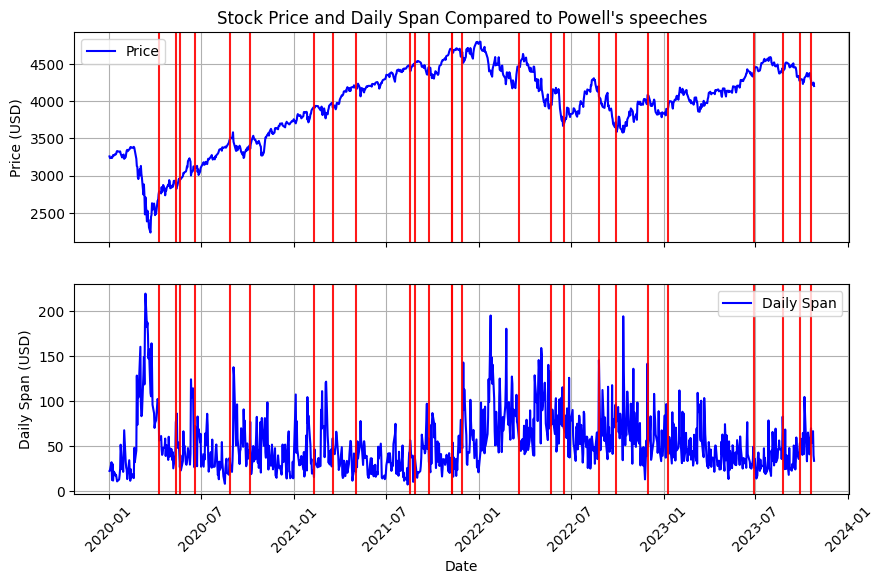

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

# Plot the Price on the top subplot
ax1.plot(sp_num.index, sp_num['Price'], color='b', label='Price')
ax1.set_ylabel('Price (USD)')
ax1.set_title("Stock Price and Daily Span Compared to Powell's speeches")
ax1.grid()

# Plot the daily_span on the bottom subplot
ax2.plot(sp_num.index, sp_num['daily_span'], color='b', label='Daily Span')
ax2.set_xlabel('Date')
ax2.set_ylabel('Daily Span (USD)')
ax2.grid()

# Add vertical lines at each date in data_df['Date']
for date in data_df['Date']:
    ax1.axvline(date, color='red', linestyle='solid', alpha=0.9)
    ax2.axvline(date, color='red', linestyle='solid', alpha=0.9)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
ax1.legend()
ax2.legend()

### 3.1 SP500 introductory visualizations

#### Check for stock market seasonalities

Text(0.5, 1.0, 'Variation in daily stock price grouped monthly 2020-2023')

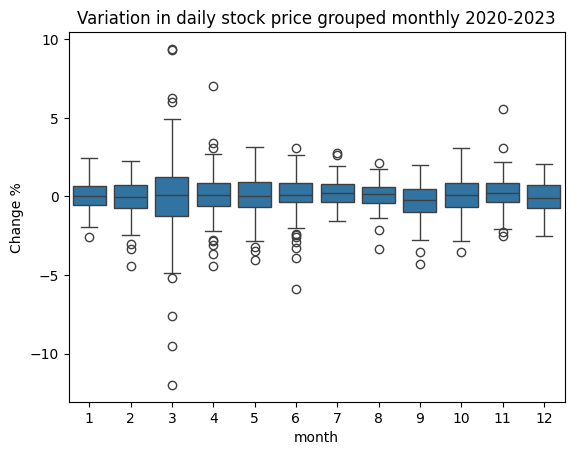

In [16]:
sp_num['year'] = sp_num.index.year
sp_num['month'] = sp_num.index.month
sns.boxplot(data=sp_num, x='month', y='Change %')
plt.title('Variation in daily stock price grouped monthly 2020-2023')

There appears to be a significant uptick in SP500 stock price variation in March - but is this due solely to stats from March 2020 when Covid became a prevalent economic disruptor? Compare with 2020 excluded below

/var/folders/_w/xxwqncbj69xfsg6qtjh7f1640000gn/T/ipykernel_80463/516535004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_2021_plus['year'] = sp_2021_plus.index.year
/var/folders/_w/xxwqncbj69xfsg6qtjh7f1640000gn/T/ipykernel_80463/516535004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_2021_plus['month'] = sp_2021_plus.index.month


Text(0.5, 1.0, 'Variation in daily stock price grouped monthly 2021-2023')

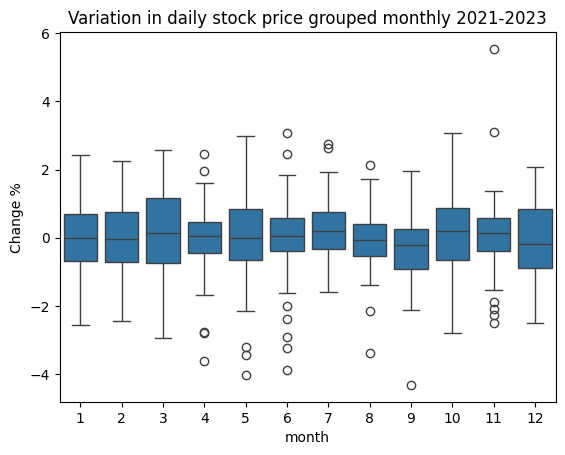

In [17]:
sp_2021_plus = sp_num[sp_num.index >= pd.to_datetime('2021-01-01')]
sp_2021_plus['year'] = sp_2021_plus.index.year
sp_2021_plus['month'] = sp_2021_plus.index.month

sns.boxplot(data=sp_2021_plus, x='month', y='Change %')
plt.title('Variation in daily stock price grouped monthly 2021-2023')

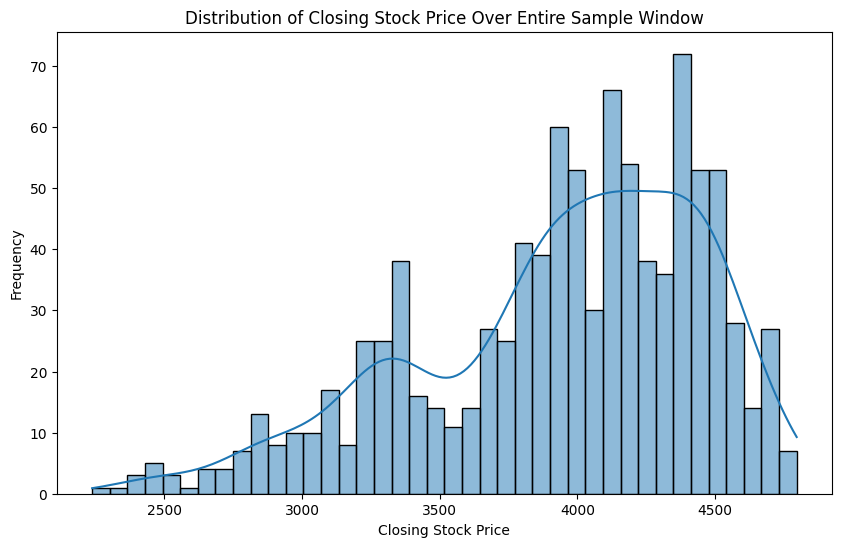

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(sp_num['Price'], bins=40, kde=True)
plt.title('Distribution of Closing Stock Price Over Entire Sample Window')
plt.xlabel('Closing Stock Price')
plt.ylabel('Frequency')
plt.show()

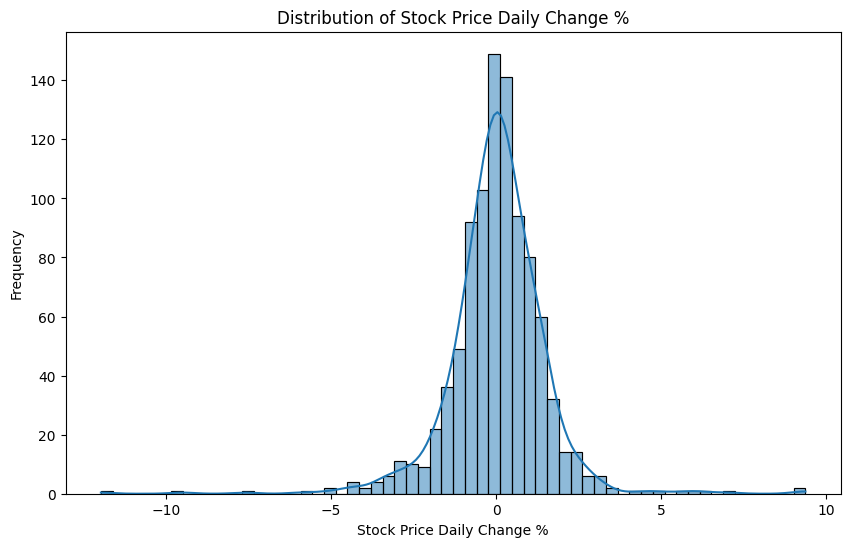

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(sp_num['Change %'], bins=60, kde=True)
plt.title('Distribution of Stock Price Daily Change %')
plt.xlabel('Stock Price Daily Change %')
plt.ylabel('Frequency')
plt.show()

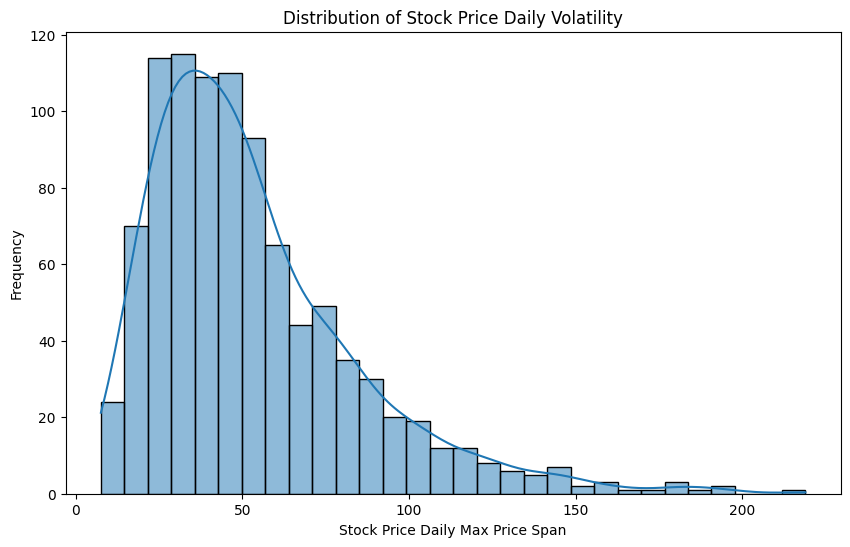

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(sp_num['daily_span'], bins=30, kde=True)
plt.title('Distribution of Stock Price Daily Volatility')
plt.xlabel('Stock Price Daily Max Price Span')
plt.ylabel('Frequency')
plt.show()

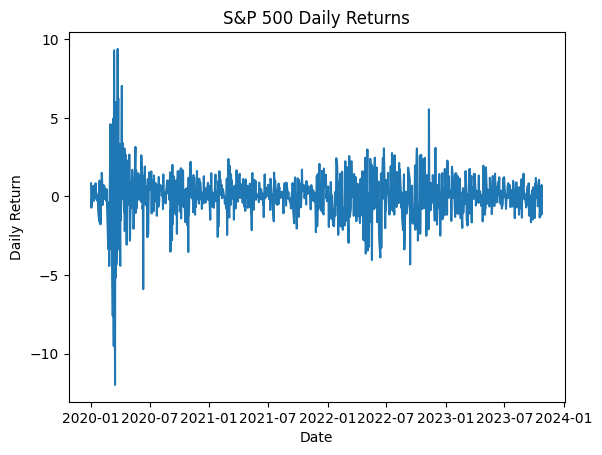

In [21]:
plt.plot(sp_num.index, sp_num['Change %'])
plt.title('S&P 500 Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

## 4. Create Structured Dataset

### 4.1 Speech Text Preprocessing

#### Bring all text into a dictionary for processing

In [22]:
# Dict to store speech text - filenames keys
speech_text_dict = {}

# all files in folder
for filename in os.listdir('data_powell_txt'):
    if filename.endswith('.txt'):
        # Read the text from the file
        with open(os.path.join(txt_folder, filename), 'r', encoding='utf-8') as file:
            text = file.read()
            file_date = filename[6:14]

        # Store the speech text in the dictionary with the filename as the key
        speech_text_dict[file_date] = text
        
print(type(file_date))

<class 'str'>


Text(0.5, 1.0, 'Length of each speech text file, in Chars')

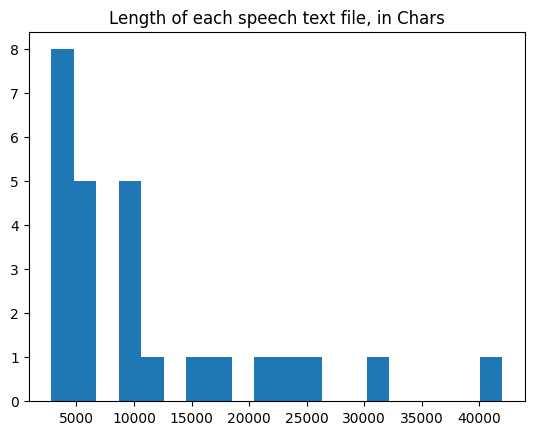

In [23]:
textlens=[]
for key in speech_text_dict:
    textlens.append(len(speech_text_dict[key]))
plt.hist(textlens, bins=20)
plt.title('Length of each speech text file, in Chars')

#### Perform text cleaning operations

In [24]:
def clean_text(text):
    # lowercase
    text = text.lower()

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Remove special characters and unnecessary punctuation
    text = ''.join(char for char in text if char not in string.punctuation)

    # Handle common contractions
    contractions = {
        "can't": "cannot",
        "don't": "do not"
    }
    for contraction, expanded_form in contractions.items():
        text = text.replace(contraction, expanded_form)

    return text

In [25]:
#Apply clean_text() function to each item from speech_text_dict

cleaned_text_dict = {}

for filename, text in speech_text_dict.items():
    cleaned_text = clean_text(text)
    cleaned_text_dict[filename] = cleaned_text

Tokenize Text Values

In [26]:
#nltk.download('punkt')

# Initialize
tokenized_speech_text_dict = {}

# Tokenize
for filename, text in cleaned_text_dict.items():
    tokens = word_tokenize(text)
    tokenized_speech_text_dict[filename] = tokens

### 4.2 Create Master df to link text data to Market Data

NOTES
make pandas df 
- each entry is a date (of a speech)
- make columns with all stock price data, % change next day, week, 2 week, month, speech len
- each col has fields including a TF-IDF of the speech, word2Vec, AND sentiment scores

- note: make df now, but after eda may add features to df like monthly variation, trend before, etc
- note: not yet sure how to feed this to time-series model for stock market

#### Define df

Each row entry of the master df will represent one of Powells speeches. They will be uniquely identifiable by their date, so this will be used to create the df.

In [27]:
master_df = pd.DataFrame(columns=['date', 'txt_tokenized'])
for key in tokenized_speech_text_dict:
    
    #extract date from tokenized dict keys
    date_obj = datetime.strptime(key, '%Y%m%d')
    
    txt = tokenized_speech_text_dict[key]
    
    #add date to master_df
    entry = pd.DataFrame([{'date':date_obj , 'txt_tokenized':txt}])
    master_df = pd.concat([master_df,entry], ignore_index=True)
    
master_df.set_index('date', inplace=True)

/var/folders/_w/xxwqncbj69xfsg6qtjh7f1640000gn/T/ipykernel_80463/3133997625.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat([master_df,entry], ignore_index=True)


In [28]:
master_df.head(2)

,txt_tokenized
date,
2022-06-17,"[for, release, on, delivery, 845, am, edt, jun..."
2022-09-28,"[for, release, on, delivery, 1015, am, edt, 91..."


In [29]:
sp_num.head(2)

,Price,Open,High,Low,Change %,daily_span,year,month
Date,,,,,,,,
2023-10-25,4201.149902,4230.040039,4230.040039,4196.250000,-1.10,33.790039,2023,10
2023-10-24,4247.680176,4235.790039,4259.379883,4219.430176,0.73,39.949707,2023,10


#### Add features from sp_num

In [30]:
for date in master_df.index:
    
    pr = sp_num.loc[date,'Price']
    master_df.at[date , 'price'] = pr
    
    O = sp_num.loc[date,'Open']
    master_df.at[date , 'open'] = O
    
    hi = sp_num.loc[date,'High']
    master_df.at[date , 'high'] = hi
    
    lo = sp_num.loc[date,'Low']
    master_df.at[date , 'low'] = lo
    
    d = sp_num.loc[date,'Change %']
    master_df.at[date , 'daily_return'] = d
    
    sp = sp_num.loc[date,'daily_span']
    master_df.at[date , 'daily_span'] = sp

master_df.head()

,txt_tokenized,price,open,high,low,daily_return,daily_span
date,,,,,,,
2022-06-17,"[for, release, on, delivery, 845, am, edt, jun...",3674.840088,3665.899902,3707.709961,3636.870117,0.22,70.839844
2022-09-28,"[for, release, on, delivery, 1015, am, edt, 91...",3719.040039,3651.939941,3736.739990,3640.610107,1.97,96.129883
2023-09-28,"[for, release, on, delivery, 400, pm, edt, sep...",4299.700195,4269.649902,4317.270020,4264.379883,0.59,52.890137
2020-05-21,"[for, release, on, delivery, 230, pm, edt, may...",2948.510010,2969.949951,2978.500000,2938.570068,-0.78,39.929932
2020-04-09,"[for, release, on, delivery, 1000, am, edt, ap...",2789.820068,2776.989990,2818.570068,2762.360107,1.45,56.209961


In [32]:
sp_num = sp_num.drop(['month', 'year'], axis=1)

In [33]:
master_df.to_csv('data_intermediate/master_df.csv')
sp_num.to_csv('data_intermediate/sp500_cleaned.csv')

In [35]:
master_df.to_pickle('data_intermediate/master_df.pkl')
sp_num.to_pickle('data_intermediate/sp500_cleaned.pkl')

## 5. Summary

This notebook served to import, inspect, and clean two datasets that will be used to predict performance of the S&P500 stock market index based on speeches by US Federal Treasury Chair Jerome Powell. The first data source is speech transcripts, located here in the 'data_powell_raw' folder and pulled from the Fed's website https://www.federalreserve.gov/newsevents/speeches.htm .
The second source is daily stock market data that was downloaded from https://www.investing.com/indices/us-spx-500-historical-data .

- Chair Powell's speeches were loaded as pdf documents, and scraped into .txt files for initial inspection.
- SP500 stock market data was imported from a .csv file, empty fields were removed, and each “object” type field that represented a number was converted to numeric values.
- Brief analysis and visualization of each data source was performed to develop understanding of the data sets in use
- Speech text was preprocessed to replace capital letters with lowercase, handle or remove punctuation, and tokenize the text
- the two data sets were unified into a single pandas dataframe, where the speeches and stock market data were matched by date
